<a href="https://colab.research.google.com/github/peterbmob/niteroi/blob/main/Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCS+Q - Molten NaCl revisited

In this tutoral, we going to revisit a classic example, namely molten NaCl. This has been studied extensively in the literature. Recently, machinel learning potentials were used. Can CCS compete?

First, we install ´ccs´ and dowload the DFT dataset, here in the form of an ASE database. Then we load the necessary modules.

In [1]:
import seaborn as sns

In [2]:
%%capture
!pip install ccs_fit
!pip install pymatgen
!wget https://github.com/Teoroo-CMC/CCS/raw/master/examples/Advanced_Tutorials/NaCl_MD/DFT.db

In [3]:
!ase db DFT.db

id|age|user |formula |calculator|  energy|natoms| fmax|pbc|  volume|charge|    mass
 1| 8M|jolla|Na32Cl32|unknown   |-194.906|    64|2.308|TTT|2227.584| 0.000|1870.073
 2| 8M|jolla|Na32Cl32|unknown   |-195.845|    64|1.484|TTT|2227.584| 0.000|1870.073
 3| 8M|jolla|Na32Cl32|unknown   |-194.170|    64|2.512|TTT|2227.584| 0.000|1870.073
 4| 8M|jolla|Na32Cl32|unknown   |-194.284|    64|2.308|TTT|2227.584| 0.000|1870.073
 5| 8M|jolla|Na32Cl32|unknown   |-195.633|    64|2.526|TTT|2227.584| 0.000|1870.073
 6| 8M|jolla|Na32Cl32|unknown   |-195.698|    64|1.902|TTT|2227.584| 0.000|1870.073
 7| 8M|jolla|Na32Cl32|unknown   |-195.272|    64|1.895|TTT|2227.584| 0.000|1870.073
 8| 8M|jolla|Na32Cl32|unknown   |-197.251|    64|1.803|TTT|2227.584| 0.000|1870.073
 9| 8M|jolla|Na32Cl32|unknown   |-195.398|    64|2.407|TTT|2227.584| 0.000|1870.073
10| 8M|jolla|Na32Cl32|unknown   |-194.457|    64|2.602|TTT|2227.584| 0.000|1870.073
11| 8M|jolla|Na32Cl32|unknown   |-195.320|    64|2.089|TTT|2227.584| 0.000|1

In [4]:
# Load in the relevant packages
import os
from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
import pandas as pd
from ase.geometry.analysis import Analysis
base=os.getcwd()
print('base is: ', os.getcwd())
Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic force

base is:  /content


# Look at the data

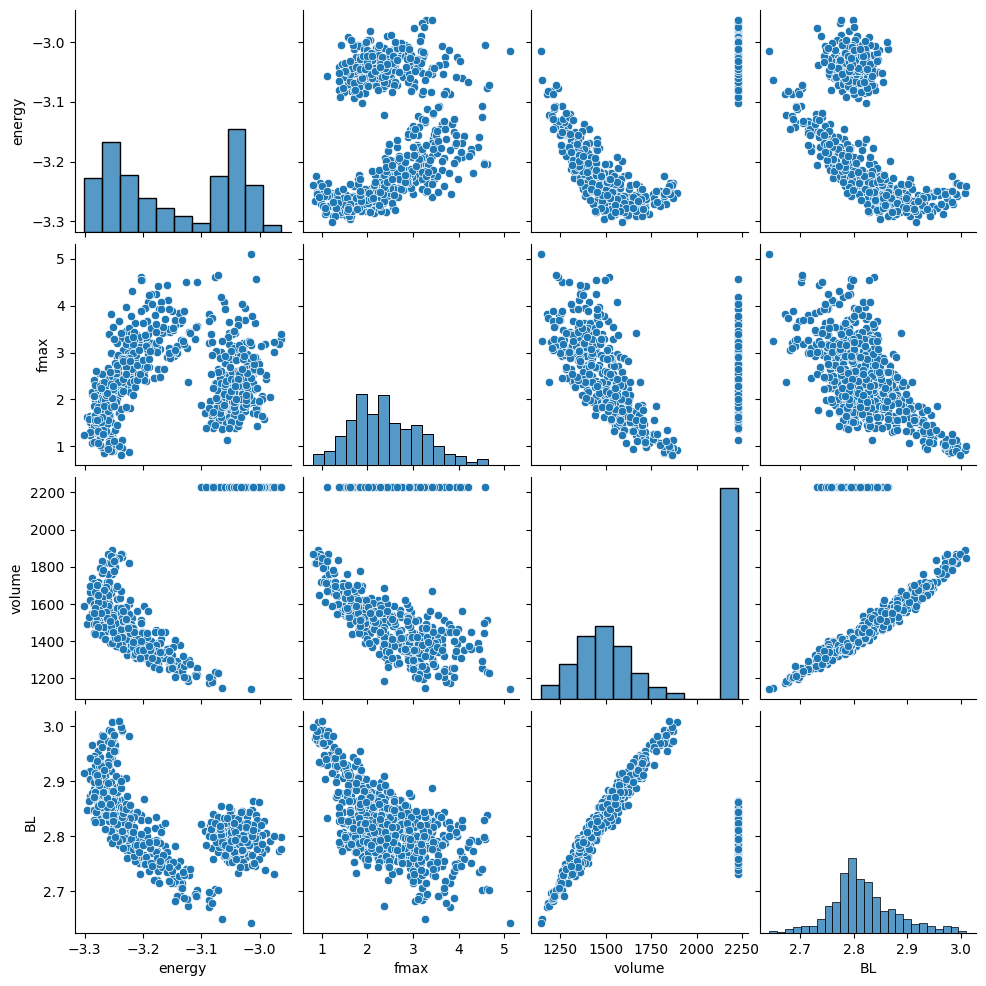

In [5]:
data=db.connect('DFT.db')

energy=[]; fmax=[]; formula=[]; BL=[]; volume=[]
df=pd.DataFrame()
for row in data.select():
  atoms=row.toatoms()
  formula.append(row.formula)
  energy.append(row.energy/len(atoms))
  fmax.append(row.fmax)
  volume.append(row.volume)
  ana = Analysis(atoms)
  Bonds = ana.get_bonds('Na', 'Cl', unique=True)
  BondValues = ana.get_values(Bonds)
  BL.append(np.average(BondValues))


df['formula']=formula
df['energy']=energy
df['fmax']=fmax
df['volume']=volume
df['BL']=BL
df
sns.pairplot(df)


In [6]:
df['volume'].unique()

array([2227.58399984, 1525.73175674, 1513.45214156, 1310.37725944,
       1256.23294915, 1471.578493  , 1853.54421001, 1527.92546258,
       1534.83801077, 1354.06480341, 1327.63923842, 1483.17044351,
       1448.04678238, 1563.89191724, 1450.63444282, 1349.62406678,
       1513.96950392, 1622.28194409, 1204.4316521 , 1554.38113935,
       1404.47364942, 1343.69087079, 1424.10636666, 1398.34542879,
       1240.16260231, 1325.86828389, 1430.40659803, 1312.68813216,
       1379.89860923, 1438.94053152, 1347.13337572, 1402.15301604,
       1533.2710727 , 1323.57911995, 1820.02336941, 1284.59885816,
       1520.9421653 , 1350.01385057, 1325.6037375 , 1363.31517541,
       1365.53767095, 1301.06051416, 1494.13557262, 1563.52049534,
       1266.62291567, 1258.04160034, 1588.26050771, 1317.94461837,
       1496.86923073, 1643.75490643, 1482.90911922, 1515.00657633,
       1820.76414106, 1772.52533676, 1393.09486582, 1443.8929977 ,
       1565.0773102 , 1572.55530402, 1292.22795951, 1537.62850

# Let us start with a smaller subset of the data.
To speed up the finding of the switching points, we start with a smaller subset of the data. Here, I want some data form the higher volume fraction and some from the lower ones.

In [7]:
os.mkdir('potential')
os.chdir('potential')

In [8]:
nu=pd.DataFrame({})
groups=['low', 'high']

for group in groups:
    if group == 'low':
        nums=np.random.randint(1,len(df.loc[df['volume']<2000]),50)
        nu[group]=nums
    if group == 'high':
        nums=np.random.randint(1,len(df.loc[df['volume']>2000]),50)
        nu[group]=nums

In [9]:
dw=db.connect('DFT_train.db')

98


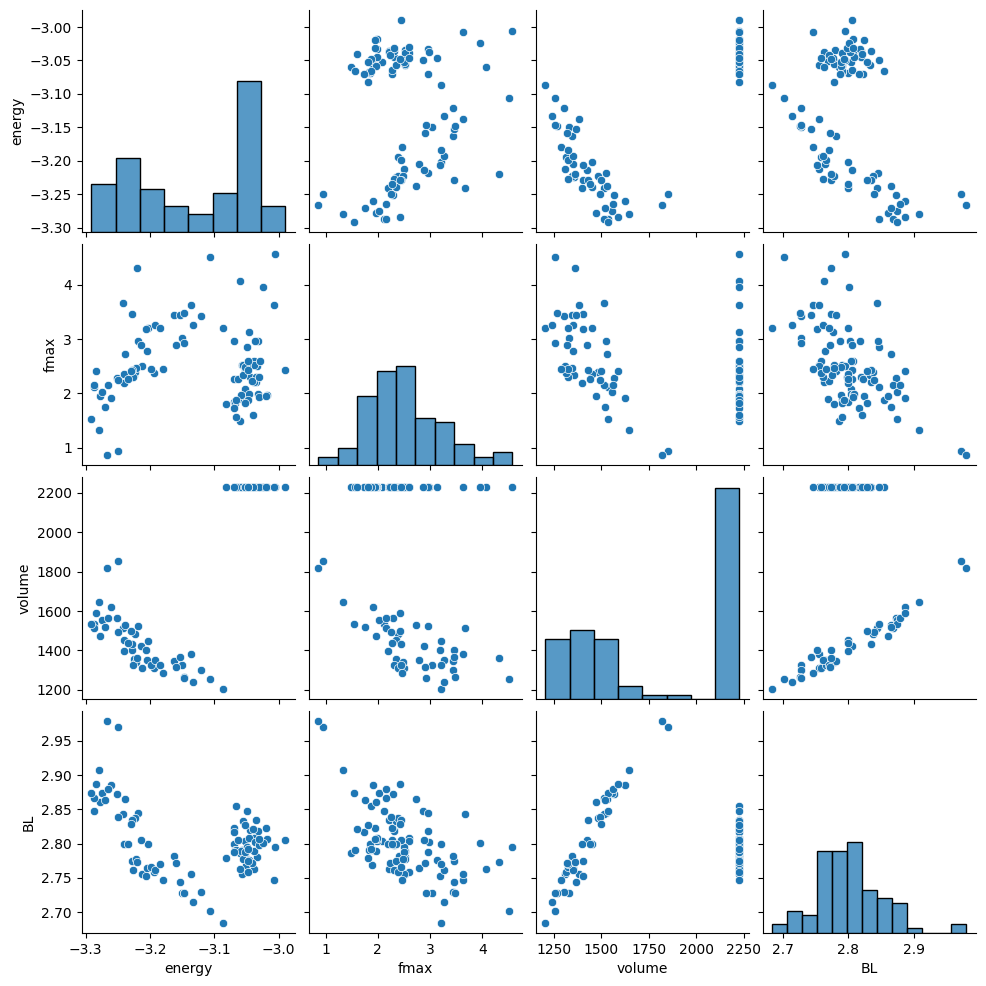

In [11]:
energy=[]; fmax=[]; formula=[]; BL=[]; volume=[]; ok=[]
data_train=pd.DataFrame({})

for group in groups:
    values=nu[group].sort_values()
    counter = 0
    if group == 'low':
        for row in data.select('volume>2000'):
            counter=counter+1
            if counter in values:
                atoms=row.toatoms()
                formula.append(row.formula)
                energy.append(row.energy/len(atoms))
                fmax.append(row.fmax)
                volume.append(row.volume)
                ana = Analysis(atoms)
                Bonds = ana.get_bonds('Na', 'Cl', unique=True)
                BondValues = ana.get_values(Bonds)
                BL.append(np.average(BondValues))
                dw.write(atoms)
    if group == 'high':
        for row in data.select('volume<2000'):
            counter=counter+1
            if counter in values:
                atoms=row.toatoms()
                formula.append(row.formula)
                energy.append(row.energy/len(atoms))
                fmax.append(row.fmax)
                volume.append(row.volume)
                ana = Analysis(atoms)
                Bonds = ana.get_bonds('Na', 'Cl', unique=True)
                BondValues = ana.get_values(Bonds)
                BL.append(np.average(BondValues))
                dw.write(atoms)

data_train['formula']=formula
data_train['energy']=energy
data_train['fmax']=fmax
data_train['volume']=volume
data_train['BL']=BL

sns.pairplot(data_train)
print(len(data_train))


In [12]:
!ase db DFT_train.db

id|age|formula |calculator|  energy|natoms| fmax|pbc|  volume|charge|    mass
 1|95s|Na32Cl32|unknown   |-194.906|    64|2.308|TTT|2227.584| 0.000|1870.073
 2|95s|Na32Cl32|unknown   |-195.845|    64|1.484|TTT|2227.584| 0.000|1870.073
 3|95s|Na32Cl32|unknown   |-194.170|    64|2.512|TTT|2227.584| 0.000|1870.073
 4|95s|Na32Cl32|unknown   |-194.284|    64|2.308|TTT|2227.584| 0.000|1870.073
 5|94s|Na32Cl32|unknown   |-195.633|    64|2.526|TTT|2227.584| 0.000|1870.073
 6|94s|Na32Cl32|unknown   |-195.698|    64|1.902|TTT|2227.584| 0.000|1870.073
 7|94s|Na32Cl32|unknown   |-195.272|    64|1.895|TTT|2227.584| 0.000|1870.073
 8|94s|Na32Cl32|unknown   |-197.251|    64|1.803|TTT|2227.584| 0.000|1870.073
 9|94s|Na32Cl32|unknown   |-195.398|    64|2.407|TTT|2227.584| 0.000|1870.073
10|93s|Na32Cl32|unknown   |-194.457|    64|2.602|TTT|2227.584| 0.000|1870.073
11|93s|Na32Cl32|unknown   |-195.320|    64|2.089|TTT|2227.584| 0.000|1870.073
12|93s|Na32Cl32|unknown   |-195.857|    64|4.069|TTT|2227.584| 0

# Fetch the data using ccs_fetch

In [13]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

q={"Na":1.0,"Cl":-1.0}
ccs_fetch(mode='CCS+Q', DFT_DB='DFT_train.db', charge_dict=q, include_forces=Fit_on_forces)


    Fetching data: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]


# Generate input
Here in the first attempt, we use a large value for `Resolution` to speed up thesearch for the switching point.

In [14]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Na": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "Cl-Cl": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Na-Na": {
                        "Rcut": 5.5,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [15]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")


    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|██████████| 16/16 [00:00<00:00, 111.46it/s]

    The best switch is (7, 13, 14) with rmse: 0.9120087718876393, corresponding to distances of [3.69 5.99 5.83] Å for element pairs ['Cl-Na', 'Cl-Cl', 'Na-Na'].


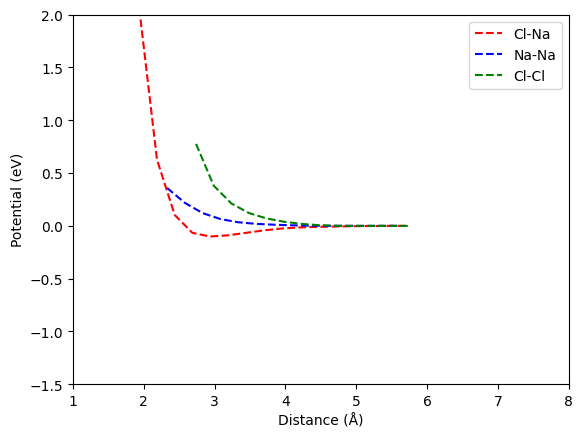

In [16]:
import numpy as np
import matplotlib.pyplot as plt

#with open("CCS_params_reference.json", "r") as f:
#    CCS_params_ref = json.load(f)

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

#r_ref = np.array(CCS_params_ref["Two_body"]["Ca-O"]["r"])
#e_ref = CCS_params_ref["Two_body"]["Ca-O"]["spl_a"]


r = np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
e = CCS_params["Two_body"]["Cl-Na"]["spl_a"]
plt.plot(r,e,'--',color='red',label="Cl-Na")

r = np.array(CCS_params["Two_body"]["Na-Na"]["r"])
e = CCS_params["Two_body"]["Na-Na"]["spl_a"]
plt.plot(r,e,'--',color='b',label="Na-Na")

r = np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
e = CCS_params["Two_body"]["Cl-Cl"]["spl_a"]
plt.plot(r,e,'--',color='g',label="Cl-Cl")

plt.xlim(1.,8)
plt.ylim(-1.5,2.0)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')

plt.legend()
plt.show()

# second run with specified switching point.

In [17]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Na": {
                        "Rcut": 5.5,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.3,
                        "range_width": 0.2
                },
                "Cl-Cl": {
                        "Rcut": 5.5,
                        "Resolution": 0.02,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Na-Na": {
                        "Rcut": 5.5,
                        "Resolution": 0.02,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [18]:
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonic constraints for pair:  Cl-Na
    Applying monotonic constraints for pair:  Cl-Cl
    Applying monotonic constraints for pair:  Na-Na
    Merging intervals for pair Cl-Cl; number of intervals reduced from 134 to 131. 
    Merging intervals for pair Na-Na; number of intervals reduced from 154 to 145. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Range search turned on for element pair Cl-Na; 10 possible switch indices in range of 2.09-2.49 Å.


    Finding optimum switch: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


    The best switch is (17, 131, 145) with rmse: 4.576680019402711, corresponding to distances of [2.39 5.47 5.34] Å for element pairs ['Cl-Na', 'Cl-Cl', 'Na-Na'].


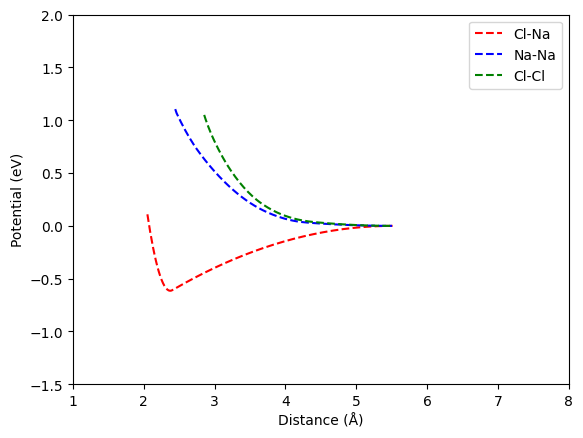

In [19]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)


r = np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
e = CCS_params["Two_body"]["Cl-Na"]["spl_a"]
plt.plot(r,e,'--',color='red',label="Cl-Na")

r = np.array(CCS_params["Two_body"]["Na-Na"]["r"])
e = CCS_params["Two_body"]["Na-Na"]["spl_a"]
plt.plot(r,e,'--',color='b',label="Na-Na")

r = np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])
e = CCS_params["Two_body"]["Cl-Cl"]["spl_a"]
plt.plot(r,e,'--',color='g',label="Cl-Cl")

plt.xlim(1.,8)
plt.ylim(-1.5,2.0)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')

plt.legend()
plt.show()

# Validation

First, let's see how it performs for the training set



In [20]:
import ase.db as db
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import pandas as pd
with open('CCS_params.json', 'r') as f:
    CCS_params=json.load(f)

df=db.connect('DFT_train.db')
model=[];DFT=[]
for row in df.select():
    struct=row.toatoms()
    nat=len(struct)
    struct.calc=CCS(CCS_params=CCS_params, q=q, charge_scaling=True)
    model.append(struct.get_total_energy()/nat)
    DFT.append(row.energy/nat)
check=pd.DataFrame({'model':model, 'DFT':DFT})

/usr/local/lib/python3.10/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


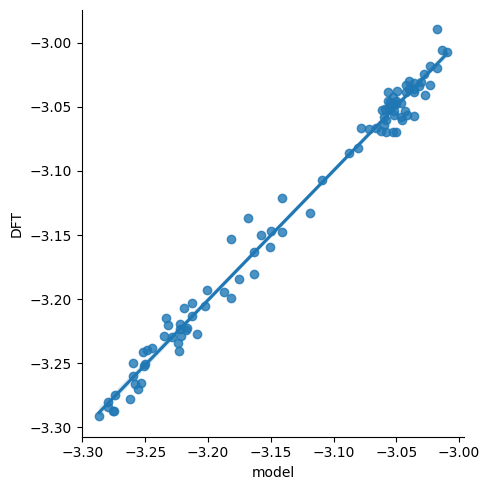

In [21]:
sns.lmplot(x='model', y='DFT',data=check,fit_reg=True)


<Axes: xlabel='model', ylabel='DFT'>

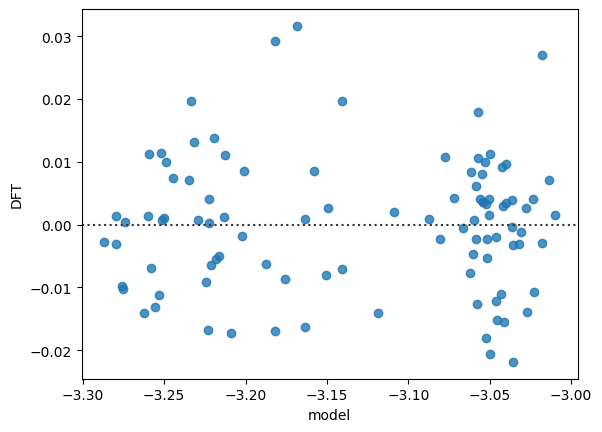

In [22]:
sns.residplot(x='model', y='DFT',data=check)

The same data is already computed by `ccs`

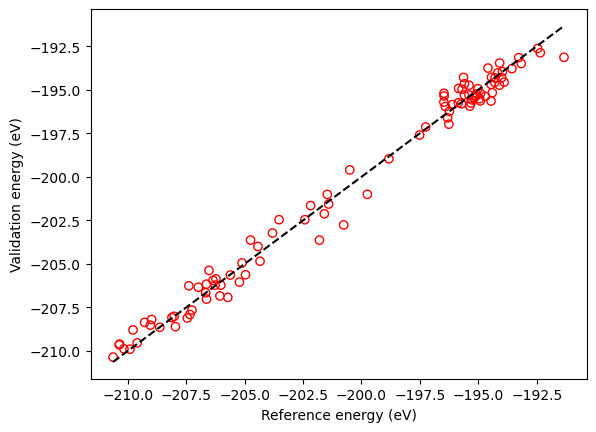

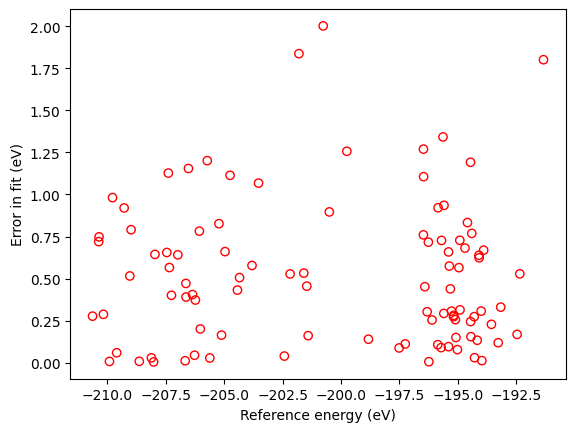

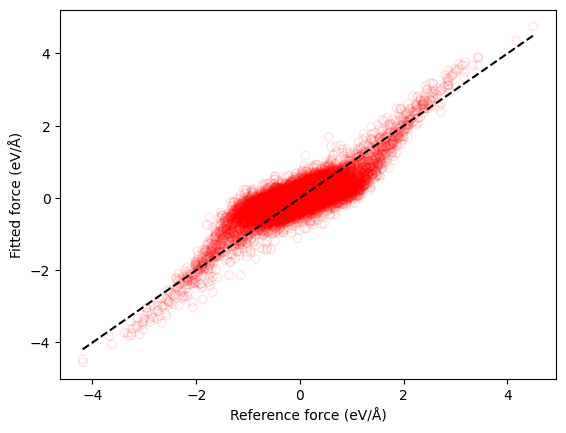

In [23]:
err=np.loadtxt("CCS_error.out")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass



This is for the data we have trained on... what about the data we have not trained on.

In [24]:
from ase import db
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import pandas as pd
with open('CCS_params.json', 'r') as f:
    CCS_params=json.load(f)

db=db.connect('../DFT.db')
model=[];DFT=[]
for row in db.select():
    struct=row.toatoms()
    nat=len(struct)
    struct.calc=CCS(CCS_params=CCS_params, q=q, charge_scaling=True)
    model.append(struct.get_total_energy()/nat)
    DFT.append(row.energy/nat)
check_val=pd.DataFrame({'model':model, 'DFT':DFT})

/usr/local/lib/python3.10/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


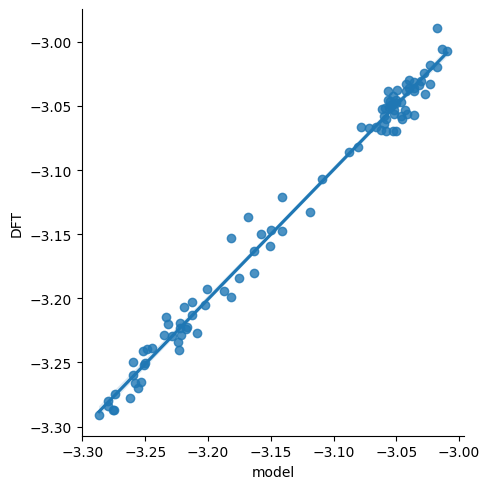

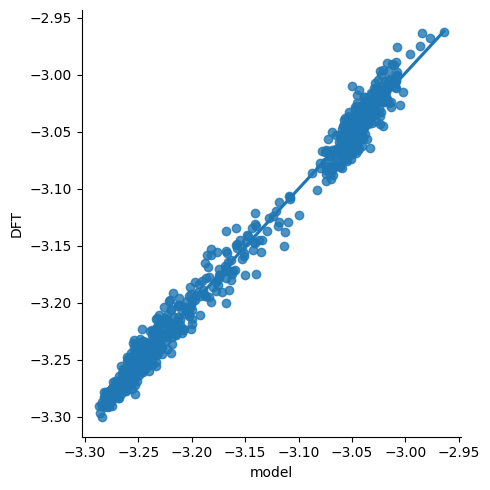

In [25]:
sns.lmplot(x='model', y='DFT',data=check,fit_reg=True)
sns.lmplot(x='model', y='DFT',data=check_val,fit_reg=True)


<Axes: xlabel='model', ylabel='DFT'>

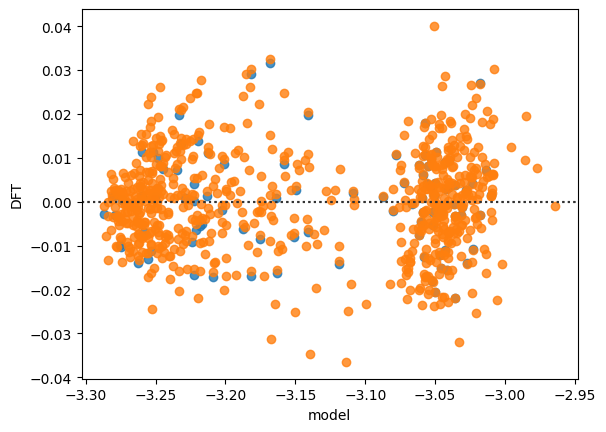

In [26]:
sns.residplot(x='model', y='DFT',data=check)
sns.residplot(x='model', y='DFT',data=check_val)

Can we do better? probably... try to add more data and rerun.

Export to other formats

In [ ]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")

#MD with ASE

In [27]:
from ase.lattice.cubic import FaceCenteredCubic
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
from ase.build import bulk
import json


json_file = open("CCS_params.json")
CCS_params = json.load(json_file)



atoms=bulk('NaCl','rocksalt',a=6.369976562933614,cubic=True)
atoms=atoms*[2,2,2]
charge_dict={"Na":1,"Cl":-1}

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=1174

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = Langevin(atoms, 2 * units.fs, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equillibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(30):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())

/usr/local/lib/python3.10/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


Initial energy: -207.01470428885435
Energy per atom: Epot = -3.235eV  Ekin = 0.163eV (T=1262K)  Etot = -3.071eV
Energy per atom: Epot = -3.146eV  Ekin = 0.130eV (T=1008K)  Etot = -3.016eV
Energy per atom: Epot = -3.152eV  Ekin = 0.148eV (T=1147K)  Etot = -3.004eV
Energy per atom: Epot = -3.131eV  Ekin = 0.135eV (T=1047K)  Etot = -2.996eV
Energy per atom: Epot = -3.152eV  Ekin = 0.130eV (T=1003K)  Etot = -3.023eV
Energy per atom: Epot = -3.155eV  Ekin = 0.151eV (T=1166K)  Etot = -3.004eV
Energy per atom: Epot = -3.132eV  Ekin = 0.178eV (T=1378K)  Etot = -2.953eV
Energy per atom: Epot = -3.147eV  Ekin = 0.175eV (T=1354K)  Etot = -2.972eV
Energy per atom: Epot = -3.142eV  Ekin = 0.160eV (T=1241K)  Etot = -2.982eV
Energy per atom: Epot = -3.127eV  Ekin = 0.172eV (T=1331K)  Etot = -2.955eV
Energy per atom: Epot = -3.116eV  Ekin = 0.160eV (T=1237K)  Etot = -2.956eV
Energy per atom: Epot = -3.116eV  Ekin = 0.160eV (T=1237K)  Etot = -2.956eV
STEP:  0  Energy per atom: Epot = -3.116eV  Ekin = 0

KeyboardInterrupt: ignored

Na Diffusion constant: 5.8399985342720605e-05  cm^2/s, Standard deviation 4.786044452061239e-06
Cl Diffusion constant: 4.320190504063021e-05  cm^2/s, Standard deviation 7.864985967909683e-06
REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870
Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 
Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 


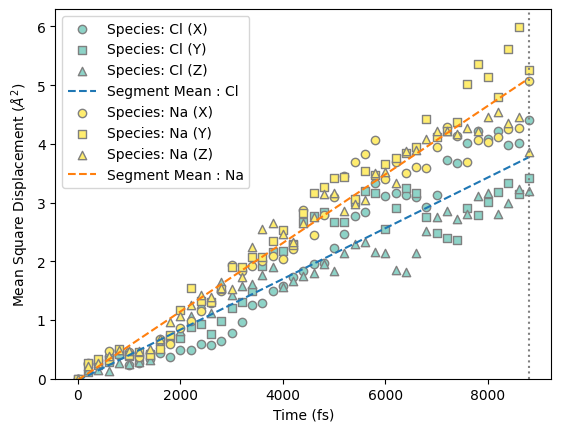

In [28]:
from ase.md.analysis import DiffusionCoefficient
from ase.io.trajectory import Trajectory
traj = Trajectory('moldyn.traj')
Df=DiffusionCoefficient(traj, 200*units.fs, atom_indices=None, molecule=False)
Df.calculate()
D=Df.get_diffusion_coefficients()
conv_factor=units.fs*0.1

print("Na Diffusion constant:", D[0][1]*conv_factor," cm^2/s, Standard deviation",D[1][1]*conv_factor)
print("Cl Diffusion constant:", D[0][0]*conv_factor," cm^2/s, Standard deviation",D[1][0]*conv_factor)


print("REFERENCE VALUES FROM GAP POTENTIALS https://pubs.acs.org/doi/full/10.1021/acs.jpcc.0c08870")

print("Na Diffusion constant:  9.78E-5 cm^2/s, Standard deviation: 0.19E-5 ")
print("Cl Diffusion constant:  7.73E-5 cm^2/s, Standard deviation: 0.11E-5 ")
Df.plot()

In [29]:
%%capture
!wget https://github.com/Teoroo-CMC/CCS/raw/master/examples/Advanced_Tutorials/MD_tutorial/RefData/ClCl.txt
!wget https://github.com/Teoroo-CMC/CCS/raw/master/examples/Advanced_Tutorials/MD_tutorial/RefData/NaCl.txt
!wget https://github.com/Teoroo-CMC/CCS/raw/master/examples/Advanced_Tutorials/MD_tutorial/RefData/NaNa.txt

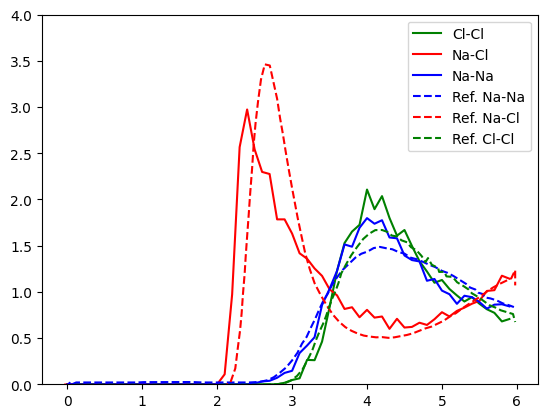

In [30]:
#Radial distribution function

import numpy as np
import itertools as iter
traj = Trajectory('moldyn.traj')

N_bins=60

h_NaNa=np.zeros((N_bins,))
h_NaCl=np.zeros((N_bins,))
h_ClCl=np.zeros((N_bins,))
counter=0
N=len(atoms)

d_NaNa=[]
d_NaCl=[]
d_ClCl=[]

mask_Na=atoms.symbols=='Na'
mask_Cl=atoms.symbols=='Cl'

for a in traj:
    counter += 1
    a.wrap()
    d_all = np.array(a.get_all_distances(mic=True)) # NxN matrix with all pair-distances
    d_NaNa.extend( d_all[mask_Na,:] [:,mask_Na].flatten()) #Extract Na-Na distances
    d_NaCl.extend( d_all[mask_Na,:] [:,mask_Cl].flatten()) #Extract Na-Cl distances
    d_ClCl.extend( d_all[mask_Cl,:] [:,mask_Cl].flatten()) #Extract Cl-Cl distances


hh,r=np.histogram(d_NaNa,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaNa = 4*hh/nrm/N/counter
h_NaNa[0]=0

hh,r=np.histogram(d_NaCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NaCl = 4*hh/nrm/N/counter
h_NaCl[0]=0

hh,r=np.histogram(d_ClCl,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_ClCl = 4*hh/nrm/N/counter
h_ClCl[0]=0


import matplotlib.pyplot as plt
Dens=len(atoms)/atoms.get_volume()

plt.ylim(0,4)
plt.plot(r[0:-1],h_ClCl/Dens,label="Cl-Cl",color="green")
plt.plot(r[0:-1],h_NaCl/Dens,label="Na-Cl",color="red")
plt.plot(r[0:-1],h_NaNa/Dens,label="Na-Na",color="blue")


ref_NaNa=np.loadtxt('NaNa.txt')
ref_NaCl=np.loadtxt('NaCl.txt')
ref_ClCl=np.loadtxt('ClCl.txt')

plt.plot(ref_NaNa[:,0],ref_NaNa[:,1,],'--',label="Ref. Na-Na",color="blue")
plt.plot(ref_NaCl[:,0],ref_NaCl[:,1,],'--',label="Ref. Na-Cl",color="red")
plt.plot(ref_ClCl[:,0],ref_ClCl[:,1,],'--',label="Ref. Cl-Cl",color="green")


plt.legend()